Data used for cleaning: 

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/about_data

Overall thoughts:
- Seems to be nearly everywhere...
- Recency is also an issue

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import seaborn as sns

In [3]:
# Load the CSV file into a GeoPandas dataframe
gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')

/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_54021/3813981924.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')


In [4]:
gdf.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,296538111H1,42,BRONX,08/14/2024,19:41:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,<18,WHITE HISPANIC,F,NaN,NaN,NaN,NaN,NaN,NaN
1,296164481,48,BRONX,02/01/2021,16:00:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,<18,BLACK,F,1011751.0,246839.0,40.844157,-73.900605,"(40.8441566000203, -73.9006054489734)",POINT (-73.9006054489734 40.8441566000203)
2,292224978,34,MANHATTAN,08/24/2024,00:38:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,UNKNOWN,F,1003658.0,250199.0,40.853392,-73.929842,"(40.853392, -73.929842)",POINT (-73.929842 40.853392)
3,298613169,116,QUEENS,12/29/2024,16:23:00,12/29/2024,16:34:00,COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,E,1057893.0,182156.0,NaN,NaN,NaN,NaN
4,292542564,73,BROOKLYN,08/30/2024,14:55:00,08/30/2024,15:00:00,COMPLETED,(null),NaN,...,NaN,18-24,BLACK,F,1008245.0,183796.0,40.671130,-73.913502,"(40.6711300016904, -73.9135020552048)",POINT (-73.9135020552048 40.6711300016904)


/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_54021/3754547159.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')


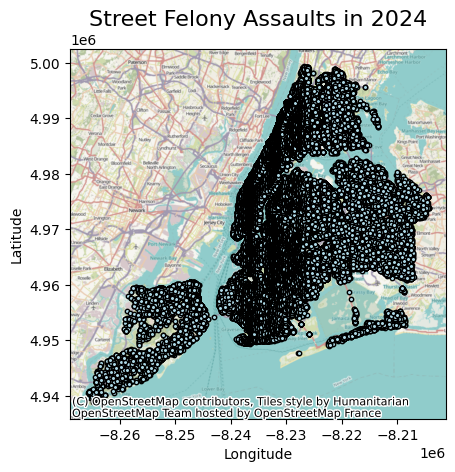

In [ ]:
gdf = pd.read_csv('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/NYPD_Complaint_Data_Current__Year_To_Date__20250220.csv')

gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf['Longitude'], gdf['Latitude']))

# First, set the CRS to WGS84 (EPSG:4326), as it's standard for lat/lon
gdf.set_crs(epsg=4326, allow_override=True, inplace=True)

# Clean the data: Filter out rows with NaN latitudes or longitudes
gdf = gdf[gdf['Latitude'].notna() & gdf['Longitude'].notna()]

# Remove the rows with invalid latitudes and longitudes
gdf = gdf[(gdf['Latitude'] <= 50) & (gdf['Latitude'] >= 40)]
gdf = gdf[(gdf['Longitude'] <= -60) & (gdf['Longitude'] >= -80)]


# Extract some additional time data
gdf['CMPLNT_FR_DT'] = pd.to_datetime(gdf['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')
gdf['Month'] = gdf['CMPLNT_FR_DT'].dt.month
gdf['DayOfWeek'] = gdf['CMPLNT_FR_DT'].dt.dayofweek  # 0 = Monday, 6 = Sunday
gdf['Year'] = gdf['CMPLNT_FR_DT'].dt.year

gdf['CMPLNT_TO_TM'] = pd.to_datetime(gdf['CMPLNT_TO_TM'], format='%H:%M:%S', errors='coerce')
gdf['Hour'] = gdf['CMPLNT_TO_TM'].apply(lambda x: x.hour if pd.notna(x) else None)


# Convert latitude and longitude to numeric values (if they are not already)
gdf['Latitude'] = pd.to_numeric(gdf['Latitude'], errors='coerce')
gdf['Longitude'] = pd.to_numeric(gdf['Longitude'], errors='coerce')

# Ensure the geometry column is in the correct CRS (WGS84)
gdf = gdf.to_crs(epsg=3857)

crime_type = 'FELONY ASSAULT'
gdf_map = gdf[gdf['OFNS_DESC'] == crime_type]

gdf_map = gdf[gdf['PREM_TYP_DESC'] == 'STREET']

gdf_map = gdf_map[gdf_map['CMPLNT_FR_DT'] >= '01/01/2024']

# Optionally, scatter plot the latitudes with color
# Points will be color-coded based on latitude
# fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometries (points) on the map
ax = gdf_map.plot(color='lightblue', edgecolor='black', marker='o', markersize=10)

ctx.add_basemap(ax)

# Add a title and labels
plt.title("Street Felony Assaults in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# min_longitude = -74.03  # Example: New York's longitude
# max_longitude = -73.90
# min_latitude = 40.70    # Example: New York's latitude
# max_latitude = 40.80

# Set the zoom level by adjusting xlim and ylim
# ax.set_xlim(min_longitude, max_longitude)
# ax.set_ylim(min_latitude, max_latitude)

# Show the plot
plt.show()

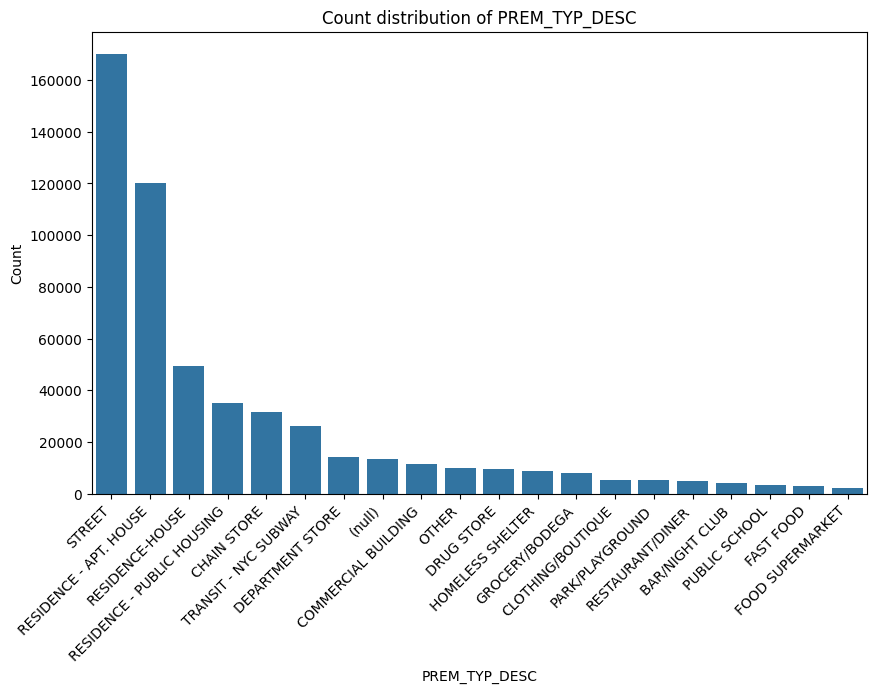

Showing count distribution for column: PREM_TYP_DESC


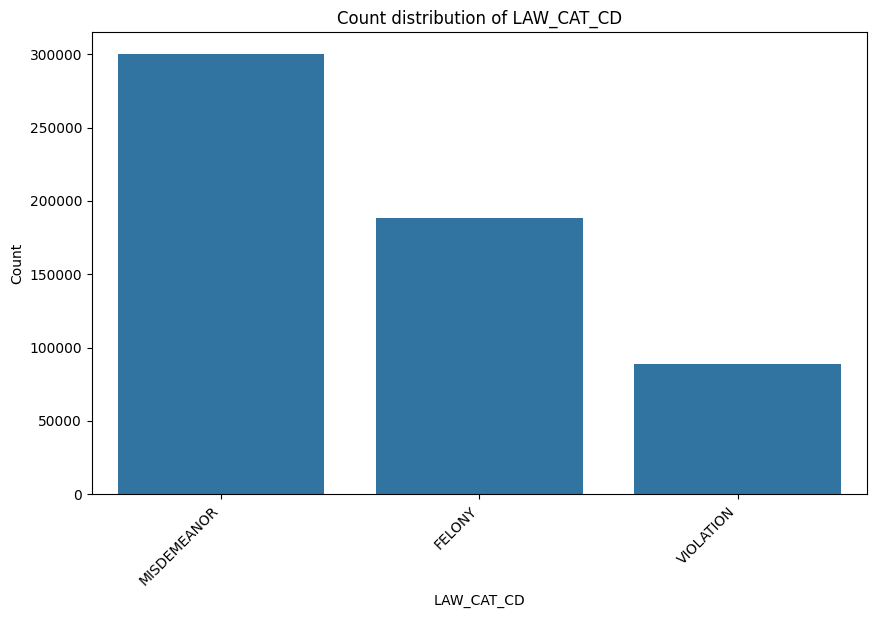

Showing count distribution for column: LAW_CAT_CD


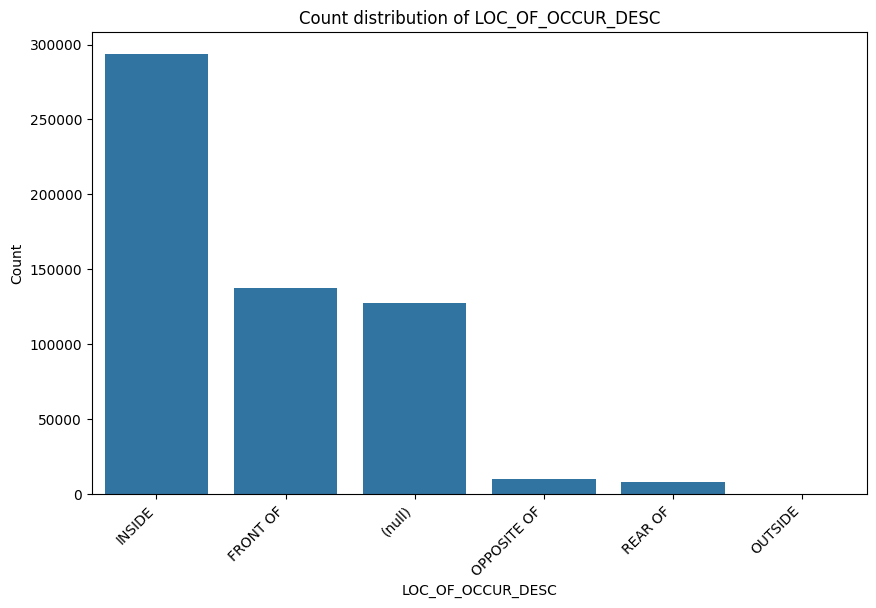

Showing count distribution for column: LOC_OF_OCCUR_DESC


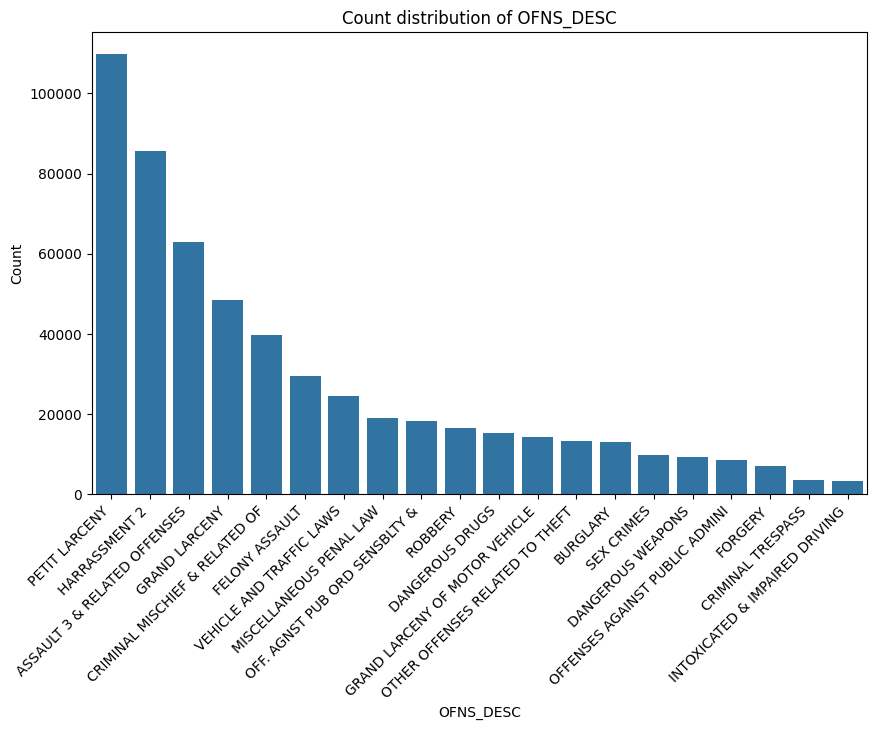

Showing count distribution for column: OFNS_DESC


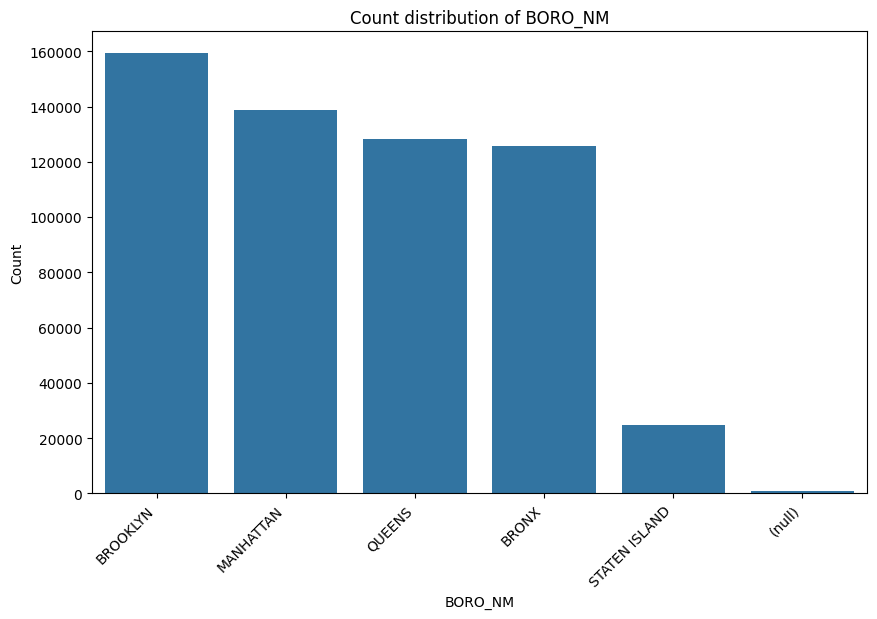

Showing count distribution for column: BORO_NM


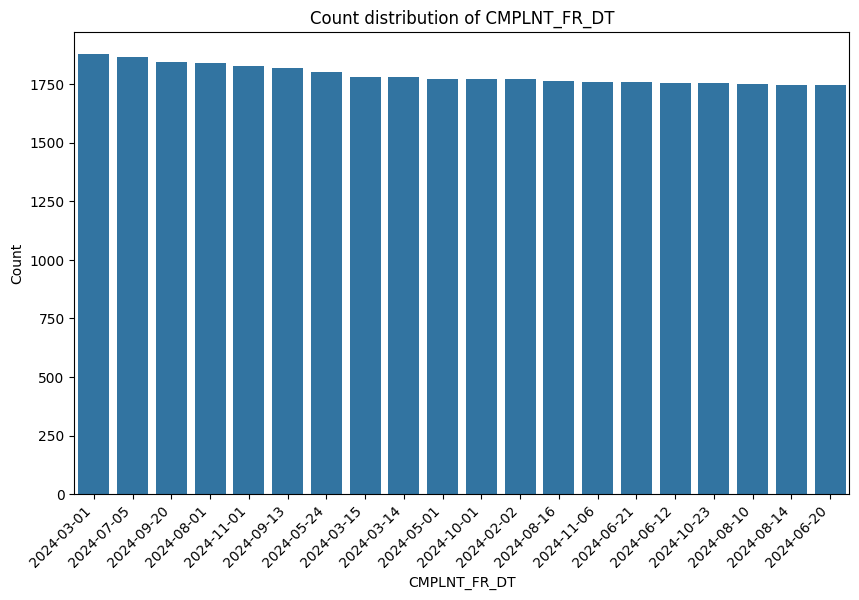

Showing count distribution for column: CMPLNT_FR_DT


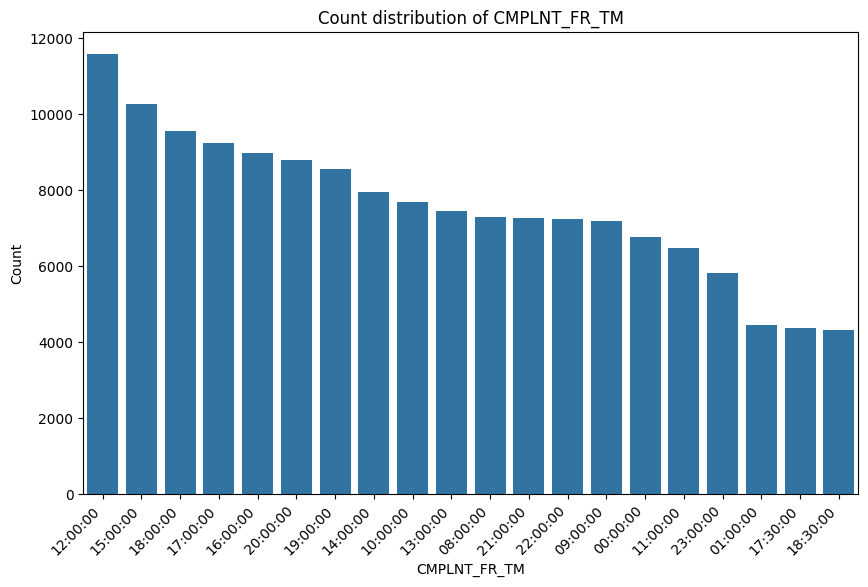

Showing count distribution for column: CMPLNT_FR_TM


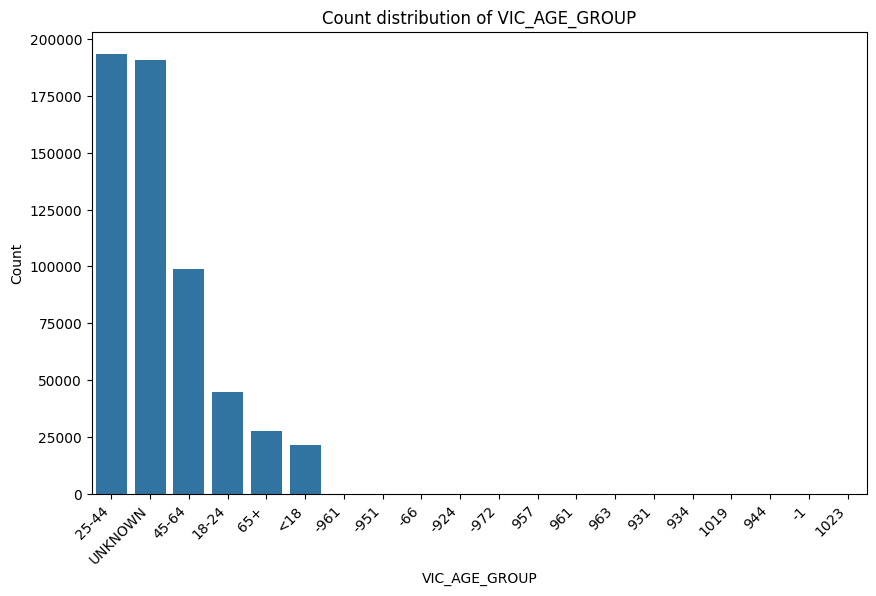

Showing count distribution for column: VIC_AGE_GROUP


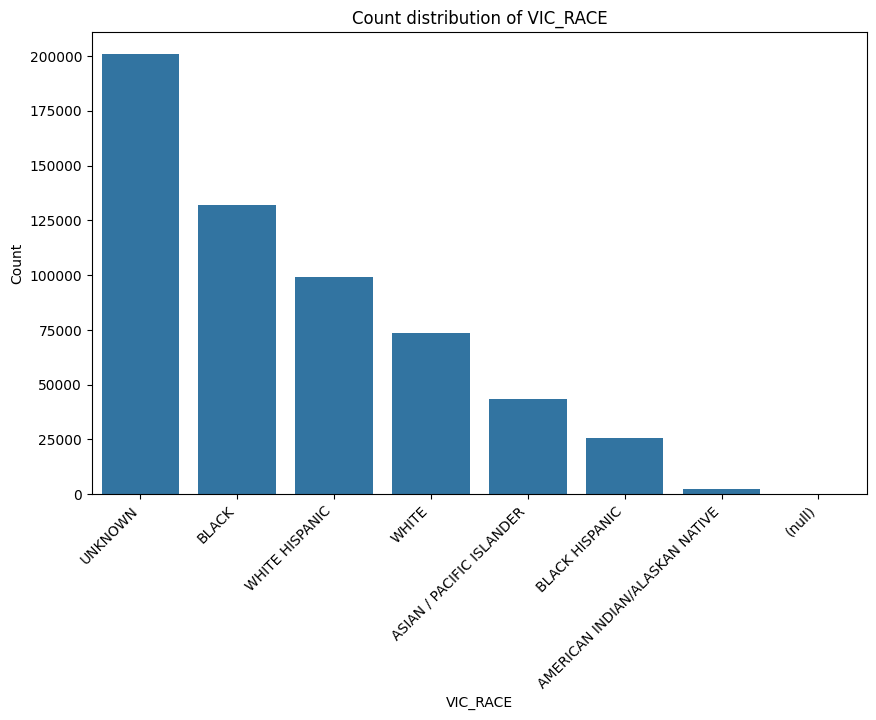

Showing count distribution for column: VIC_RACE


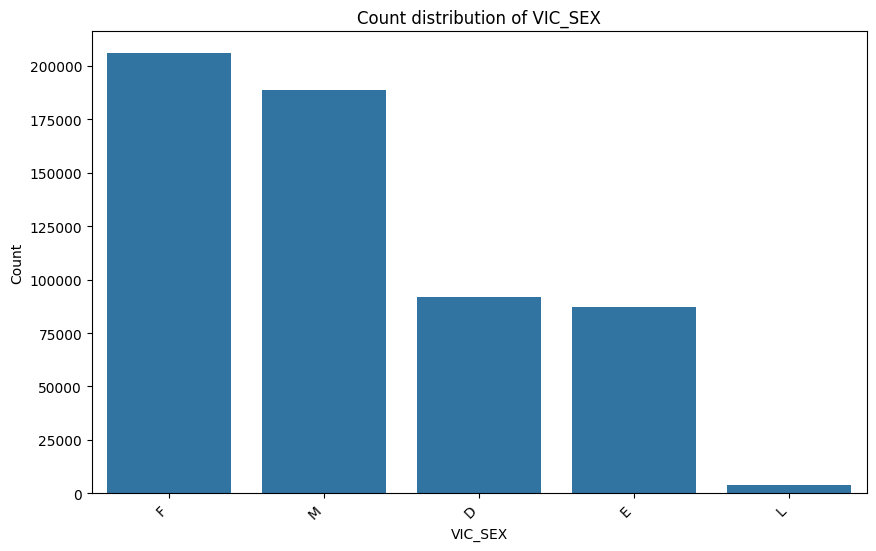

Showing count distribution for column: VIC_SEX


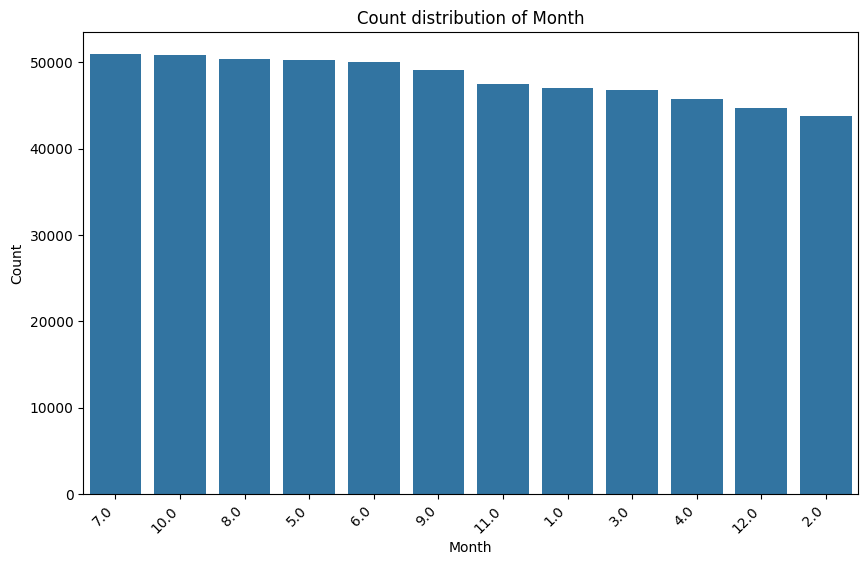

Showing count distribution for column: Month


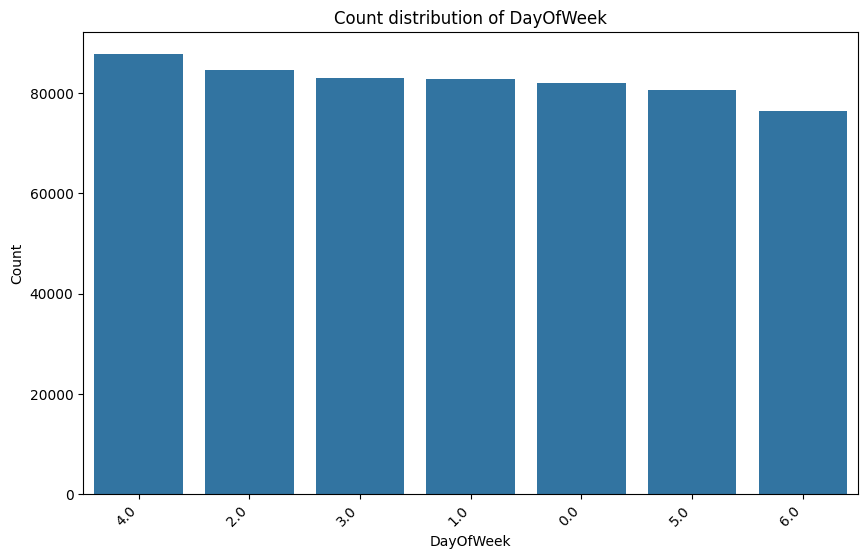

Showing count distribution for column: DayOfWeek


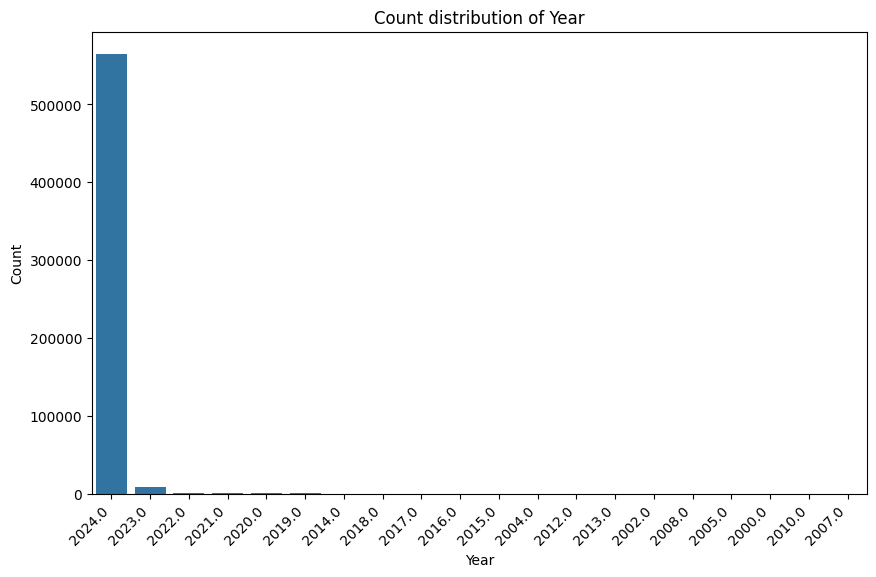

Showing count distribution for column: Year


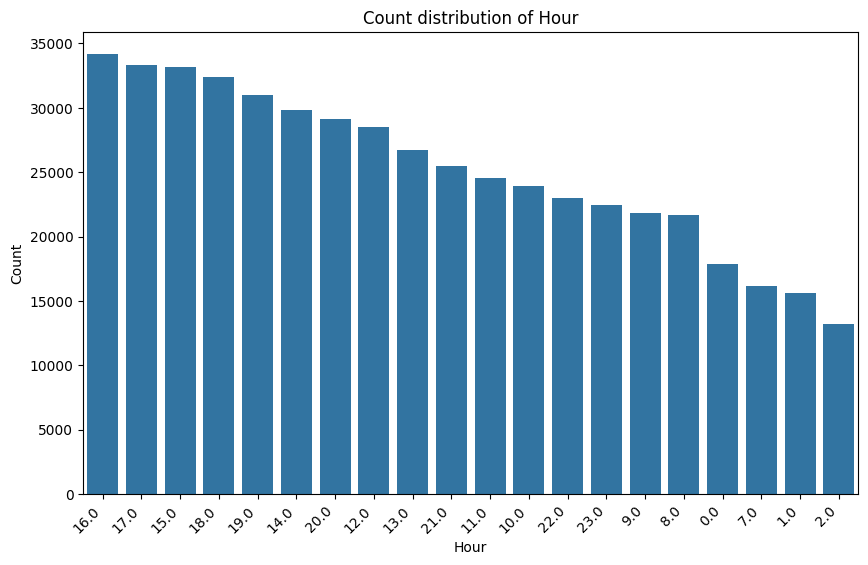

Showing count distribution for column: Hour


In [6]:
columns_of_interest = ['PREM_TYP_DESC', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Month', 'DayOfWeek', 'Year', 'Hour']

for column in columns_of_interest:
    # Get the count of unique values and filter out low frequency categories if needed
    counts = gdf[column].value_counts()
    
    # Optionally, limit the number of categories shown, e.g., show top 10 most frequent
    top_counts = counts.head(20)  # Adjust this number based on your needs
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x=gdf[column], order=top_counts.index)  # Order by frequency of top counts
    plt.title(f'Count distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # Rotate the x-axis labels if there are many categories
    plt.xticks(rotation=45, ha='right')
    
    # Show the plot
    plt.show()
    
    print(f"Showing count distribution for column: {column}")


In [7]:
gdf_final = gdf[columns_of_interest]
gdf_final.head()

,PREM_TYP_DESC,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Month,DayOfWeek,Year,Hour
1,PARK/PLAYGROUND,FELONY,INSIDE,RAPE,BRONX,2021-02-01,16:00:00,<18,BLACK,F,2.0,0.0,2021.0,NaN
2,RESIDENCE - APT. HOUSE,FELONY,INSIDE,ARSON,MANHATTAN,2024-08-24,00:38:00,25-44,UNKNOWN,F,8.0,5.0,2024.0,NaN
4,STREET,FELONY,(null),RAPE,BROOKLYN,2024-08-30,14:55:00,18-24,BLACK,F,8.0,4.0,2024.0,15.0
5,FAST FOOD,FELONY,INSIDE,FELONY ASSAULT,BRONX,2024-06-09,12:37:00,65+,BLACK,M,6.0,6.0,2024.0,NaN
6,RESIDENCE-HOUSE,FELONY,INSIDE,ARSON,BRONX,2024-12-26,07:56:00,25-44,BLACK,M,12.0,3.0,2024.0,NaN


In [35]:
ny_roads_1 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/tl_2024_36005_roads/tl_2024_36005_roads.shp')

ny_roads_2 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/tl_2024_36047_roads/tl_2024_36047_roads.shp')

ny_roads_3 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/tl_2024_36061_roads/tl_2024_36061_roads.shp')

ny_roads_4 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/tl_2024_36081_roads/tl_2024_36081_roads.shp')

ny_roads_5 = gpd.read_file('/Users/naliniramanathan/projects/se_1/team2-wed-spring25/data/tl_2024_36085_roads/tl_2024_36085_roads.shp')

In [36]:
ny_roads_final = gpd.GeoDataFrame(pd.concat([ny_roads_1, ny_roads_2, ny_roads_3, ny_roads_4, ny_roads_5], ignore_index=True))

In [45]:
ny_roads_final.head()

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1104691956808,Bryant Ave Ovp,M,S1710,"LINESTRING (-8225275.725 4986093.954, -8225238..."
1,110391525903,Putnam Ave W Exd,M,S1400,"LINESTRING (-8226541.205 4995102.864, -8226525..."
2,110391524230,E 177th St Exd,M,S1400,"LINESTRING (-8215606.625 4985417.158, -8215508..."
3,110391524663,Depot Pl Exd,M,S1400,"LINESTRING (-8229795.074 4989038.072, -8229761..."
4,110391523687,Rae St Exd,M,S1400,"LINESTRING (-8227887.726 4985461.433, -8227884..."


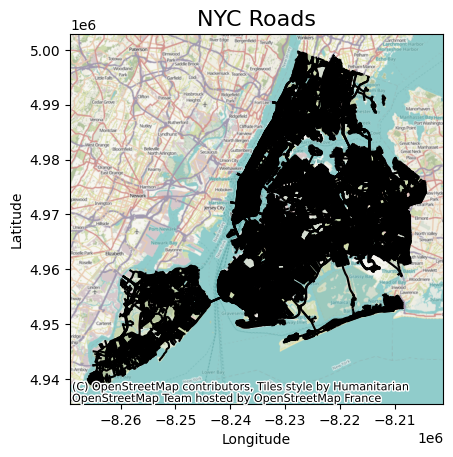

In [41]:
ny_roads_final = ny_roads_final.to_crs(epsg=3857)

ax = ny_roads_final.plot(edgecolor='black')

ctx.add_basemap(ax)

# Add a title and labels
plt.title("NYC Roads", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# min_longitude = -74.03  # Example: New York's longitude
# max_longitude = -73.90
# min_latitude = 40.70    # Example: New York's latitude
# max_latitude = 40.80

# Set the zoom level by adjusting xlim and ylim
# ax.set_xlim(min_longitude, max_longitude)
# ax.set_ylim(min_latitude, max_latitude)

# Show the plot
plt.show()

In [61]:
roads_gdf.columns

Index(['LINEARID', 'FULLNAME', 'RTTYP', 'MTFCC', 'geometry'], dtype='object')

In [54]:
roads_gdf = ny_roads_final.to_crs("EPSG:2263")  # EPSG:2263 is a state plane CRS in feet
points_gdf = gdf.to_crs("EPSG:2263")  # Reproject points as well

# Step 3: Buffer the roads by 20 feet
buffer_radius = 20  # Buffer size in feet
roads_gdf['geometry'] = roads_gdf.buffer(buffer_radius)

joined_gdf = gpd.sjoin(points_gdf, roads_gdf, how='inner', predicate='intersects')

In [71]:
joined_gdf.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon', 'New Georeferenced Column', 'geometry', 'Month',
       'DayOfWeek', 'Year', 'Hour', 'index_right', 'LINEARID', 'FULLNAME',
       'RTTYP', 'MTFCC'],
      dtype='object')

In [84]:
# Group by 'OFNS_DESC' and 'LINEARID', then count occurrences of 'CMPLNT_NUM'
summary_table = joined_gdf.groupby(['LINEARID'])['CMPLNT_NUM'].count().reset_index()

# Optional: Rename the count column for clarity
summary_table = summary_table.rename(columns={'CMPLNT_NUM': 'CMPLNT_COUNT'})

In [85]:
# join summary table with the original data
summary_table_new = summary_table.merge(ny_roads_final[['LINEARID', 'geometry']], on='LINEARID', how='inner')
len(summary_table_new)

14394

In [ ]:
summary_table_new

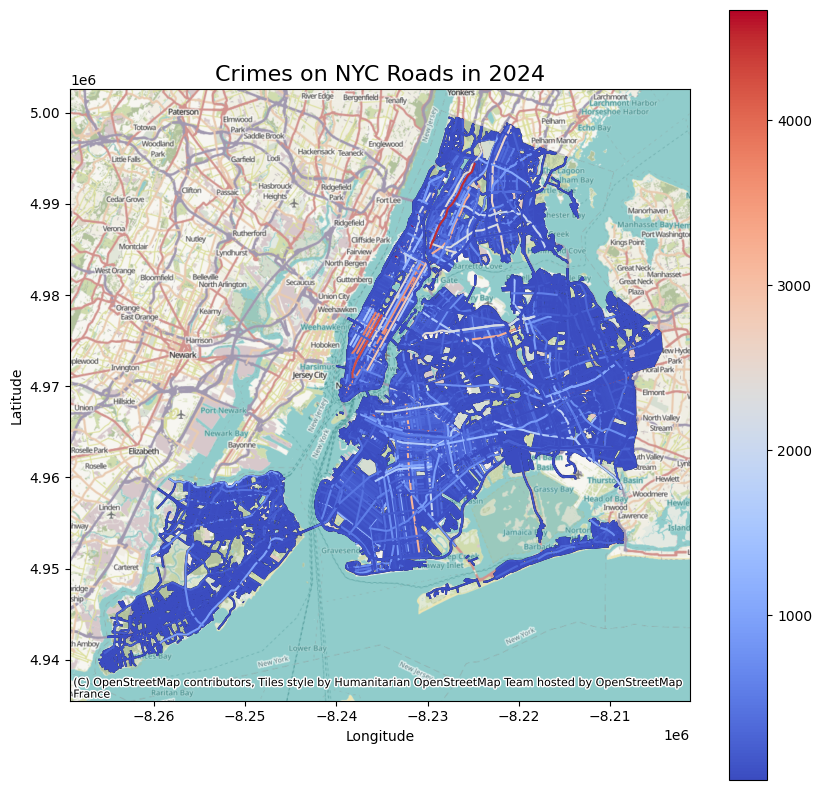

In [86]:
# Map the summary table

summary_table_new = gpd.GeoDataFrame(summary_table_new, geometry='geometry')
crime_counts_per_road = joined_gdf.groupby('LINEARID')['CMPLNT_NUM'].count().reset_index()
summary_table_new = summary_table_new.to_crs(epsg=3857)

# Plot the geometries (points) on the map
ax = summary_table_new.plot(edgecolor='black', figsize=(10, 10))   

summary_table_new.plot(column='CMPLNT_COUNT', ax=ax, legend=True, cmap='coolwarm', markersize=10)
ctx.add_basemap(ax)
plt.title("Crimes on NYC Roads in 2024", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

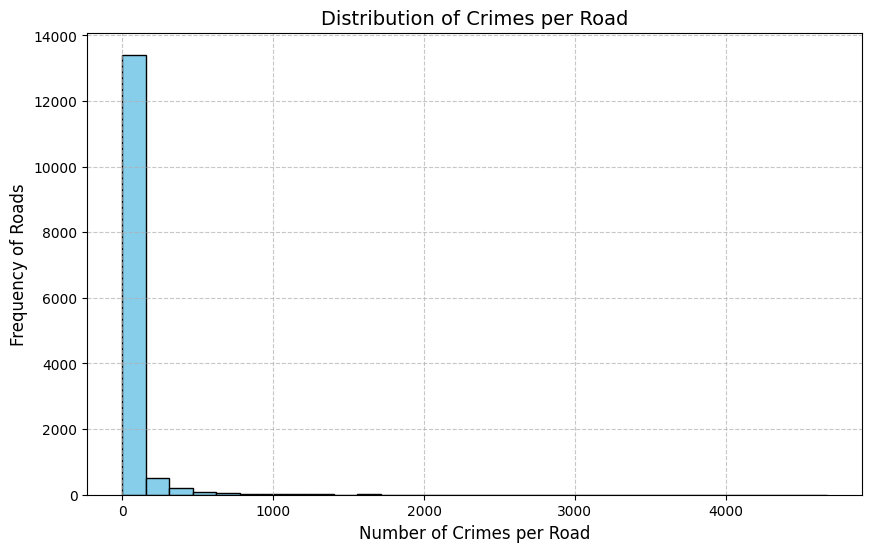

In [82]:
# Step 1: Group by 'LINEARID' and count crimes (CMPLNT_NUM)
crime_counts_per_road = joined_gdf.groupby('LINEARID')['CMPLNT_NUM'].count().reset_index()

# Step 2: Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(crime_counts_per_road['CMPLNT_NUM'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Crimes per Road', fontsize=14)
plt.xlabel('Number of Crimes per Road', fontsize=12)
plt.ylabel('Frequency of Roads', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
from shapely.geometry import LineString, Point

def split_road_at_intersections(road, other_roads):
    subsegments = [road]  # Start with the whole road as one segment
    
    for other_road in other_roads:
        if road.intersects(other_road):
            intersection = road.intersection(other_road)
            
            if isinstance(intersection, Point):  # If the intersection is a point
                # Split the road at the intersection point
                subsegments = []
                start = road.interpolate(road.project(Point(road.coords[0])))  # Starting point
                end = road.interpolate(road.project(Point(road.coords[-1])))  # Ending point
                
                first_segment = LineString([start, intersection])
                second_segment = LineString([intersection, end])
                
                subsegments.append(first_segment)
                subsegments.append(second_segment)
    
    return subsegments

In [43]:
len(ny_roads_final)

22091

In [ ]:
# Figure out a way to make this faster or run in background
split_roads = []
for road in ny_roads_final['geometry']:
    other_roads = ny_roads_final['geometry'].loc[ny_roads_final['geometry'] != road]
    subsegments = split_road_at_intersections(road, other_roads)
    split_roads.extend(subsegments)

# Convert the result to a GeoDataFrame
subsegments_gdf = gpd.GeoDataFrame(geometry=split_roads)

KeyboardInterrupt: 